In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')


from ipywidgets import interact
import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction

In [2]:
from dimred.data.loader import LoadOne
from dimred.data.preprocess import MinMaxScalar,ZeroMeanScalar,MeanMaxScalar
# dimred.
from dimred.data.preprocess import scale_sanity,Scalar

from dimred.models.linear.transform import Kurtosis
from dimred.models.linear.transform import co_variance,co_kurtosis
from dimred.tester.plotting import plot_embedding,plot_compare
from dimred.tester.metrics import mean_sq_error,mean_abs_error

In [3]:
def reshape_step(xinput):
    nvs = xinput.shape[-1]  ## reshapeing to oned array for cantera
    xinp = xinput.reshape(-1,nvs)
    return xinp

In [21]:
def ck_calc(xscaled):
    shape = xscaled.shape
    n = shape[0]
    nvar = shape[1]
    CK = np.zeros((nvar, nvar, nvar, nvar))
    
    for i in range(0,(nvar)):
        for j in range(0,(nvar)):
            for k in range(0,(nvar)):
                for l in range(0,(nvar)):
                    CK[i,j,k,l] = (np.sum(xscaled[:,i]*xscaled[:,j]*xscaled[:,k]*xscaled[:,l]))
#         print(i,j)
    
    CK=CK/n
    CV= cv_calc(xscaled)
    
    for i in range(0,(nvar)):
        for j in range(0,(nvar)):
            for k in range(0,(nvar)):
                for l in range(0,(nvar)):
                    CK[i,j,k,l] = (CK[i,j,k,l] - CV[i,j]*CV[k,l] - CV[i,k]*CV[j,l] - CV[i,l]*CV[j,k])
    
    CK_m = CK.reshape(nvar*nvar*nvar, nvar)
    return CK_m

In [5]:
def cv_calc(xscaled):
    shape = xscaled.shape
    n = shape[0]
    nvar = shape[1]
    
    CV = np.zeros((nvar, nvar))
    
    for i in range(0,(nvar)):
        for j in range(0,(nvar)):
            CV[i,j] = (np.sum(xscaled[:,i]*xscaled[:,j]))
#         print(i,j)
    
    CV=CV/(n)
    return CV

In [6]:
def calc_mean_max(xinp):
    mn = xinp.mean(axis=0)
    mx = abs(xinp).max(axis=0)
    
    return mn, mx

In [219]:
mn, mx = calc_mean_max(temp)

In [220]:
print(mn, mx, mn-mx)

[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.] [-5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]


In [7]:
def scaling(xinp, add, factor, flag):
    shape = xinp.shape
    nvar = shape[1]
    x_scaled = np.zeros(shape)
    
    if flag == 0: #scaling
        print('scaling')
        for f in range(nvar):
            x_scaled[:,f] = (xinp[:,f] - add[f])/factor[f]
    
    if flag ==1: #reverse scaling
        print('reverse scaling')
        for f in range(nvar):
            x_scaled[:,f] = (xinp[:,f]*factor[f]) + add[f]
   
    return x_scaled

In [16]:
def scale_cv_reconst(data_matrics, retain_pc = 4):
    xinp = reshape_step(data_matrics).copy() # restructuring array to n*features
    shape = xinp.shape                       # shape
    
    mean, mx = calc_mean_max(xinp)
    x_scaled = scaling(xinp, mean, mx, 0)      # scaling data
    
    CV = cv_calc(x_scaled)
    
    u_cv, s_cv, vh_cv = np.linalg.svd(CV)
    
    Zq = np.matmul(xinp, u_cv[:,0:retain_pc]) # data in eigenspace
    
    xreconstruct_cv = np.matmul(Zq, u_cv[:,0:retain_pc].tranpose()) # reconstructed data
    
    xreconstruct_cv_rs = scaling(xreconstruct_cv, mean, mx, 1) # reverse scaling of data
    
    return xreconstruct_cv_rs

In [9]:
def scale_ck_reconst(data_matrics, retain_pc = 4):
    xinp = reshape_step(data_matrics).copy() # restructuring array to n*features
    shape = xinp.shape                       # shape
    x_scaled = scaling(xinp, 0)      # scaling data 
    
    CK_m = ck_calc(x_scaled)                 # kurtosis calculation
    
    u_ck, s_ck, vh_ck = np.linalg.svd(CK_m, full_matrices=False, compute_uv=True, hermitian=False) # SVD    

    Zq = np.matmul(xinp, vh_ck[0:retain_pc,:].T)       # data in eigenspace
    
    xreconstruct_ck = np.matmul(Zq, vh_ck[0:retain_pc,:]) # reconstructed data
    
    xreconstruct_ck = scaling(xreconstruct_ck, 1) # reverse scaling of data
    
    return xreconstruct_ck

In [17]:
loader = LoadOne()

reading file autoignition.1.0000E-05.field.mpi...


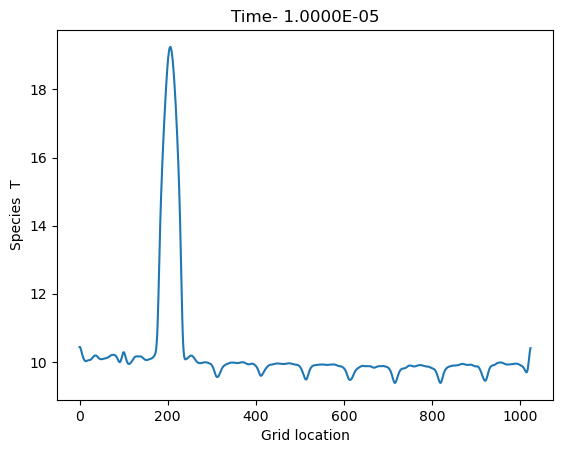

In [18]:
time_step = 100

xrig = loader.getTime(time_step,verbose=3)[:,:13]
loader.plotLine(spec=12,time=time_step)

In [19]:
xrig.shape

(1024, 13)

In [20]:
xnew = scale_cv_reconst(xrig, retain_pc = 4)

scaling


AttributeError: 'numpy.ndarray' object has no attribute 'tranpose'

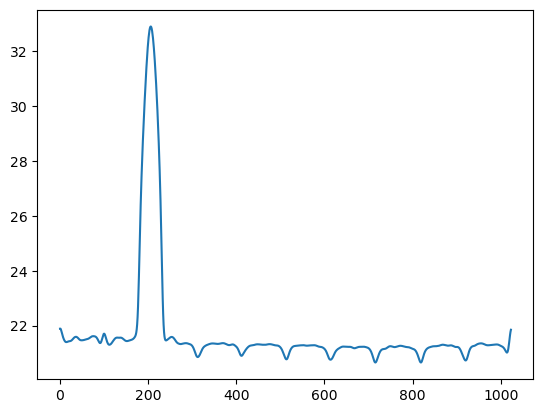

In [14]:
plt.plot(xnew[:,12])

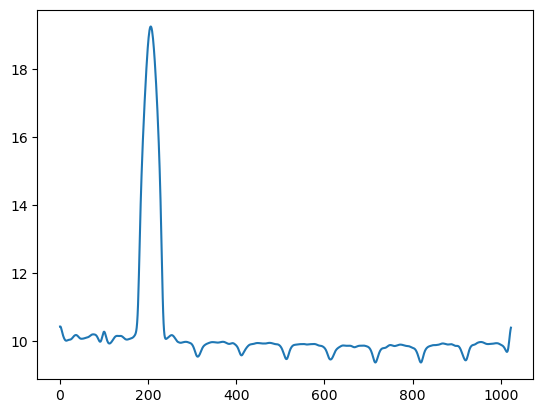

In [15]:
plt.plot(xrig[:,12])

In [151]:
x_scalingTest = np.zeros(xrig.shape)
for f in range(13):
    mx = np.max(abs(xrig[:,f]))
    mn = np.mean(xrig[:,f])
    x_scalingTest[:,f] = (xrig[:,f] - mn)/mx

In [22]:
# input file
fname1 = 'x_b5.txt'
fname2 = 'y_b5.txt'

fid1 = open(fname1,'r')
fid2 = open(fname2,'r')

x = np.fromfile(fid1, sep=' ')
y = np.fromfile(fid2, sep=' ')

nx = x.size    # size of data
nv = 2         # number of variables

# data matrix
X = np.zeros((nx,nv))
X[:,0] = x
X[:,1] = y

In [24]:
X.shape

(625, 2)

In [34]:
v1 = ck_calc(X)
v2 = co_kurtosis(X)

In [35]:
v1 = cv_calc(X)
v2 = co_variance(X)

In [36]:
v2

array([[0.82721962, 0.3947209 ],
       [0.3947209 , 0.47245016]])

In [42]:
v1

array([[0.82721962, 0.3947209 ],
       [0.3947209 , 0.47245016]])

In [41]:
np.sum(v1-v2)

0.0

In [35]:
v1 = cv_calc(X)
v2 = co_variance(X)

In [36]:
v2

array([[0.82721962, 0.3947209 ],
       [0.3947209 , 0.47245016]])

In [42]:
v1

array([[0.82721962, 0.3947209 ],
       [0.3947209 , 0.47245016]])

In [41]:
np.sum(v1-v2)

0.0

In [43]:
v1 = ck_calc(X)
v2 = co_kurtosis(X)

In [48]:
# x,y

In [50]:
np.sum(x*y**3)/len(x)

0.49924845732118794

In [51]:
np.sum(y*x**3)/len(x)

0.47224130565568084

In [44]:
v2

array([[ 4.41870337, -0.50732131],
       [-0.50732131, -0.68939607],
       [-0.50732131,  0.01565029],
       [ 0.01565029, -0.0602094 ],
       [-0.50732131,  0.01565029],
       [ 0.01565029, -0.0602094 ],
       [-0.68939607, -0.0602094 ],
       [-0.0602094 , -0.07438832]])

In [45]:
v1

array([[ 4.41870337, -0.50732131],
       [-0.50732131, -0.21936516],
       [-0.50732131, -0.21936516],
       [-0.21936516, -0.0602094 ],
       [-0.50732131, -0.21936516],
       [-0.21936516, -0.0602094 ],
       [-0.21936516, -0.0602094 ],
       [-0.0602094 , -0.07438832]])

In [46]:
np.sum(v1-v2)

-8.326672684688674e-16

Text(0.5, 0, 'Time (ms)')

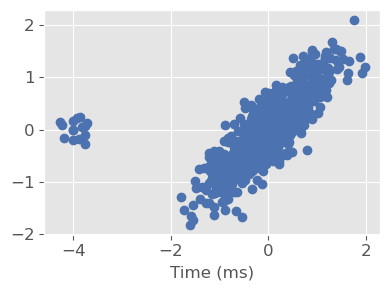

In [120]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (4,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(x,y, 'o')
plt.xlabel('Time (ms)')
# plt.ylabel('Reaction rate');

In [131]:
def scaleData(nf, v):

    # compute mean
    v_mean = np.mean(v, axis=0)
#     print(v_mean)
    v_max = np.max(np.abs(v), axis=0)
#     print(v_max)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        v[:, i] = (v[:, i] - v_mean[i])/v_max[i]
#         v[:, i] = (v[:, i])/v_max[i]

    return None

Xs = np.zeros((nx,nv)) # scaled data matrix
Xs = np.copy(X)

scaleData(nv,Xs)
print(Xs)

[[ 0.04579083 -0.11694883]
 [ 0.10642451  0.18288682]
 [-0.00360463 -0.20817833]
 ...
 [-0.91550439  0.07314406]
 [-0.96979324  0.03714631]
 [-0.1043739  -0.49983294]]


Text(0.5, 0, 'Time (ms)')

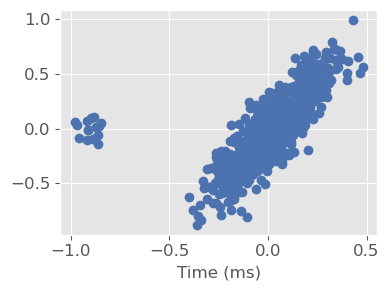

In [134]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (4,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(Xs[:,0],Xs[:,1], 'o')
plt.xlabel('Time (ms)')
# plt.ylabel('Reaction rate');

[[ 0.04579083 -0.11694883]
 [ 0.10642451  0.18288682]
 [-0.00360463 -0.20817833]
 ...
 [-0.91550439  0.07314406]
 [-0.96979324  0.03714631]
 [-0.1043739  -0.49983294]]


Text(0.5, 0, 'Time (ms)')

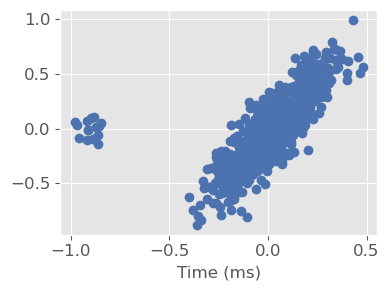

In [136]:
X_ls = scaling(X,0)
print(X_ls)
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (4,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(X_ls[:,0],X_ls[:,1], 'o')
plt.xlabel('Time (ms)')
# plt.ylabel('Reaction rate');

In [141]:
cv_calc(X_ls)

array([[0.04474126, 0.04428097],
       [0.04428097, 0.10827869]])

In [145]:
print(ck_calc(X_ls))

[[ 0.01189471 -0.00285924]
 [-0.00285924 -0.00266447]
 [-0.00285924 -0.00266447]
 [-0.00266447 -0.00158121]
 [-0.00285924 -0.00266447]
 [-0.00266447 -0.00158121]
 [-0.00266447 -0.00158121]
 [-0.00158121 -0.00394168]]


In [143]:
X_new = scale_cv_reconst(X, retain_pc = 1)

Text(0.5, 0, 'Time (ms)')

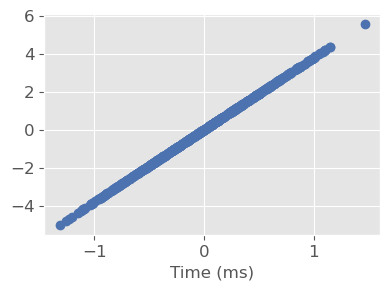

In [144]:
X_new = scale_cv_reconst(X, retain_pc = 1)
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (4,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(X_new[:,0],X_new[:,1], 'o')
plt.xlabel('Time (ms)')

Text(0.5, 0, 'Time (ms)')

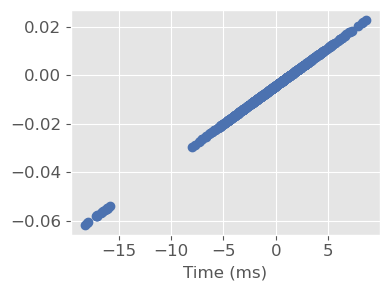

In [146]:
X_new = scale_ck_reconst(X, retain_pc = 1)
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (4,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
plt.figure()
plt.plot(X_new[:,0],X_new[:,1], 'o')
plt.xlabel('Time (ms)')